In [24]:
import requests
import json
import os
import tarfile
from urllib.parse import urlparse
from datetime import datetime, timedelta
import rasterio as rio
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from rasterio.transform import xy
from matplotlib import pyplot
from rasterio.plot import show
from rasterio.plot import show_hist

In [12]:
os.environ['USERNAME'] = ''
os.environ['PASSWORD'] = ''
os.environ['REGION'] = 'CU'
os.environ['GEOJSON'] = 'geojson/meadow.geojson'
os.environ['DATA_SET_NAME'] = 'ARD_TILE'
os.environ['PRODUCT'] = 'SR'
os.environ['FILEPATH'] = './tmp/'

In [13]:
class Phenology: 
    def get_apikey(username, password):
        payload = dict(username=username, password=password, catalogId='EE', authType='EROS')
        data = dict(jsonRequest=json.dumps(payload))
        r = requests.post('https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/login', data=data)
        creds = r.json()
        return creds['data']
    
    def get_scenes(apiKey, region, horizontal, vertical, start_date, end_date):
        myfilter = {
                "filterType": "and", 
                "childFilters": [
                    {"filterType":"value","fieldId":21789,"value":region}, #Grid Region
                    {"filterType":"value","fieldId":21787,"value":horizontal}, #Horizontal
                    {"filterType":"value","fieldId":21788,"value":vertical}, #Vertical
                ]
            }
        startDate, endDate = Phenology.get_dates(start_date, end_date)
        temporalfilter = {
            "startDate": startDate,
            "endDate": endDate
        }
        request_code = 'search'
        baseurl = f'https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/{request_code}'
        payload = {'apiKey':apiKey, 
                   'datasetName': os.environ['DATA_SET_NAME'], 
                   "temporalFilter": temporalfilter,
                   'additionalCriteria': myfilter,  
                   'maxResults':10000}
        data = dict(jsonRequest=json.dumps(payload))
        r = requests.get(baseurl, params=data)
        response = r.json()
        return response
    
    # 15 day buffer before start date and after end date
    def get_dates(start_date, end_date):
        start_date = datetime(int(start_date[:4]), int(start_date[5:7]), int(start_date[-2:]))
        end_date = datetime(int(end_date[:4]), int(end_date[5:7]), int(end_date[-2:]))
        start = (start_date - timedelta(days=15)).strftime('%Y-%m-%d')
        end = (end_date + timedelta(days=15)).strftime('%Y-%m-%d')
        return start, end
    
    def get_url(entityId, apiKey, product=os.environ['PRODUCT']):
        request_code = 'download'
        baseurl = f'https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/{request_code}'
        payload = {'apiKey':apiKey, 
                   'datasetName': os.environ['DATA_SET_NAME'], 
                   'entityIds':[entityId],
                   'products':[product]} #these are 'download codes' from above
        data = dict(jsonRequest=json.dumps(payload))
        r = requests.get(baseurl, params=data)
        data = r.json()['data']
        download_url = r.json()['data'][0]['url']
        p = urlparse(download_url)
        name = os.path.basename(p.path)
        return os.environ['FILEPATH'] + name, download_url
    
    def download(filename, url):
        chunks = 1024*1024
        with requests.get(url, stream=True) as r:
            with open(filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=chunks):
                    f.write(chunk)
    
    def calculate_NDVI(nir_data, red_data, longitudes, latitudes):
        np.seterr(invalid='ignore')
        x, y = np.meshgrid(longitudes, latitudes)
        nir_data = nir_data.astype(float)
        nir_data = nir_data.astype(float)
        data = np.array([nir_data.flatten(), red_data.flatten(), x.flatten(), y.flatten()])
        data = np.rot90(data)
        # filter out negative values and values greater than 10,000
        data = data[np.logical_and(np.logical_and(data[:, 0] >= 0, data[:, 1] >= 0), np.logical_and(data[:, 0] <= 10000, data[:, 1] <= 10000))]
        ndvi = np.array([np.divide(np.subtract(data[:, 0], data[:, 1]), np.add(data[:, 0], data[:, 1]))])
        ndvi = np.rot90(ndvi)
        data = np.append(data, ndvi, 1)
        # filter out invalid ndvi values
        data = data[np.logical_and(data[:, 4] >= -1, data[:, 4] <= 1)]
        # calculation of values
        maximum = data[:, 4].max() if len(data) != 0 else 'invalid'
        flowering = data[np.logical_and(data[:, 4] <= .425, data[:, 4] >= .375)]
        FF = round(len(flowering)/len(data), 2) if len(data) != 0 else 'invalid'
        VF = 1 - FF if len(data) != 0 else 'invalid'
        return {
            'avg': round(data[:, 4].mean(), 2) if len(data) != 0 else 'invalid',
            'max': round(maximum, 2) if len(data) != 0 else 'invalid',
            'min': round(data[:, 4].min(), 2) if len(data) != 0 else 'invalid',
            'std': round(data[:, 4].std(), 2) if len(data) != 0 else 'invalid',
            'FF': FF,
            'VF': VF,
            'coordinates': json.dumps(data[data[:, 4] == maximum][:, 2:4].round(4).tolist()) if len(data) != 0 else 'invalid'
        }
        
    def get_reflectance(data):
        data = data.astype(float)
        # filters values between 0 and 10000
        data = np.divide(data[np.logical_and(data >= 0,data <= 10000)], 10000)
        return {'avg': round(data.mean(), 2) if data.size != 0 else 'invalid', 
                'max': round(data.max(), 2) if data.size != 0 else 'invalid', 
                'min': round(data.min(), 2) if data.size != 0 else 'invalid', 
                'std': round(data.std(), 2) if data.size != 0 else 'invalid'
               }
    
    def get_statistical_values(tar):
        values = {}
        with tarfile.open(tar) as tar:
            for member in tar.getmembers():
                if member.name[-8:] in ['SRB5.tif','SRB4.tif', 'SRB3.tif', 'SRB2.tif']:
                    path = os.environ['FILEPATH'] + member.name
                    tar.extract(member, path=os.environ['FILEPATH'])
                    outpath = Phenology.reproject(path, path + 'cropped')
                    data = Phenology.crop_raster_data(outpath)
                    if member.name[-8:] == 'SRB4.tif':   
                        values['red_data'] = data
                        with rio.open(outpath) as src:
                            transform = src.meta['transform']
                            values['longitudes'] = xy(transform, [x for x in range(src.width)], [y for y in range(src.width)])[0]
                            values['latitudes'] = xy(transform, [x for x in range(src.height)], [y for y in range(src.height)])[1]
                    if member.name[-8:] == 'SRB3.tif':
                        values['green_data'] = data
                    if member.name[-8:] == 'SRB2.tif':
                        values['blue_data'] = data
                    if member.name[-8:] == 'SRB5.tif':
                        values['nir_data'] = data
        return {'blue_ref': Phenology.get_reflectance(values['blue_data']), 
                'green_ref': Phenology.get_reflectance(values['green_data']), 
                'red_ref': Phenology.get_reflectance(values['red_data']), 
                'NDVI': Phenology.calculate_NDVI(values['nir_data'], 
                                                 values['red_data'], 
                                                 values['longitudes'], 
                                                 values['latitudes'])}

    def reproject(inpath, outpath, dst_crs='EPSG:4326'):
        with rio.open(inpath) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rio.open(outpath, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rio.band(src, i),
                        destination=rio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
        return outpath
                    
    # returns cropped data and crops the tif file
    def crop_raster_data(tif_path):
        with rio.open(tif_path) as src:
            extent_geojson = env['predecessor_outputs']['2']['extent_geojson']
            out_image, out_transform = mask(src, shapes=[json.loads(extent_geojson)], crop=True)
            out_meta = src.meta.copy()
            out_meta.update({"driver": "GTiff",
                          "height": out_image.shape[1],
                          "width": out_image.shape[2],
                          "transform": out_transform})
            # only needed for the lat lon coordinates
            with rio.open(tif_path, "w", **out_meta) as dest:
                dest.write(out_image)
            return out_image[0]
        
    # returns cropped data and crops the tif file with geojson 
    def crop_raster_data_geojson(tif_path,extent_geojson):
        with rio.open(tif_path) as src:
            out_image, out_transform = mask(src, shapes=[json.loads(extent_geojson)], crop=True)
            out_meta = src.meta.copy()
            out_meta.update({"driver": "GTiff",
                          "height": out_image.shape[1],
                          "width": out_image.shape[2],
                          "transform": out_transform})
            # only needed for the lat lon coordinates
            with rio.open(tif_path, "w", **out_meta) as dest:
                dest.write(out_image)
            return out_image[0]    

In [130]:
# We are going to read in the green band reflectances
# Reflectances are not converted to top of atmosphere (TOA) reflectance, but is in Digital Numbers (DN)
# Meadows are covered in snow early part of year, and as snow melts we should see the decrease in reflectance
# towards green-up and flowering

In [131]:
# Below example assumes files have been already clipped for a region of interest ( a meadow at Mt Rainier)
# Earth Explorer download of Zip file done
#B4_* RED
#B3_* GREEN
#B2_* BLUE
#B5_* NIR
green_meadow_March = rio.open("scenes/landsat_images/03302019/raster_files/B3_site4.TIF")
green_meadow_May = rio.open("scenes/landsat_images/05012019/raster_files/B3_site4.TIF")
green_meadow_June = rio.open("scenes/landsat_images/06112019/raster_files/B3_site4.TIF")
green_meadow_July = rio.open("scenes/landsat_images/07292019/raster_files/B3_site4.TIF")
green_meadow_August = rio.open("scenes/landsat_images/08142019/raster_files/B3_site4.TIF")


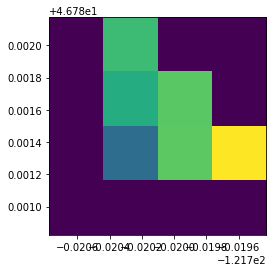

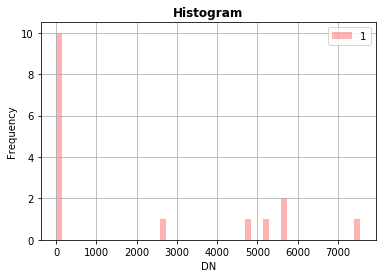

In [132]:
# Green band in March
show(green_meadow_March)
show_hist(green_meadow_March, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

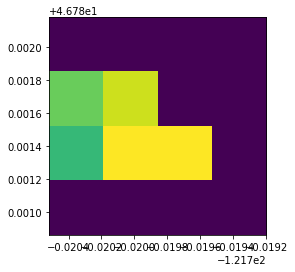

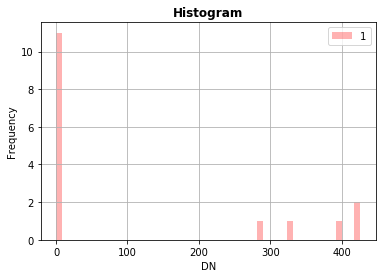

In [133]:
# Green band in August
show(green_meadow_August)
show_hist(green_meadow_August, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

In [134]:
import seaborn as sns
import pandas as pd

In [135]:
df_phenology_March=pd.DataFrame(green_meadow_March.read(1))
df_phenology_May=pd.DataFrame(green_meadow_May.read(1))
df_phenology_June=pd.DataFrame(green_meadow_June.read(1))
df_phenology_July=pd.DataFrame(green_meadow_July.read(1))
df_phenology_August=pd.DataFrame(green_meadow_August.read(1))

In [136]:
# Use the individual reflectances for each image
def calculate_mean_reflectance(row):
    return np.mean([row[0] , row[1], row[2], row[3]])

In [137]:
# Use .apply to save the new column for mean reflectance
df_phenology_March['mean_reflectance'] = df_phenology_March.apply(calculate_mean_reflectance,axis=1)
df_phenology_May['mean_reflectance'] = df_phenology_May.apply(calculate_mean_reflectance,axis=1)
df_phenology_June['mean_reflectance'] = df_phenology_June.apply(calculate_mean_reflectance,axis=1)
df_phenology_July['mean_reflectance'] = df_phenology_July.apply(calculate_mean_reflectance,axis=1)
df_phenology_August['mean_reflectance'] = df_phenology_August.apply(calculate_mean_reflectance,axis=1)

In [138]:
df_phenology_March['Month']='March'
df_phenology_May['Month']='May'
df_phenology_June['Month']='June'
df_phenology_July['Month']='July'
df_phenology_August['Month']='August'


In [139]:
df_pheno=[df_phenology_March,df_phenology_May,df_phenology_June,df_phenology_July,df_phenology_August]

In [140]:
df_pheno=pd.concat(df_pheno)

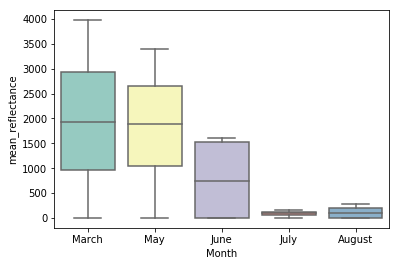

In [142]:
# Higher reflectance in March 
# July - possibly peak green-up
# August - uptick can be construed as flowering
ax = sns.boxplot(x="Month",y="mean_reflectance", palette="Set3",data=df_pheno)